**Q1: define the following**:
* Gaussian Processes (GPs) and stochastic processes generally
* Variational inference using the Evidence Lower Bound (ELBO)

i) A Gaussian Process (GP) is a way to model functions without making strong assumptions about their shape. It treats functions as distributions rather than fixed equations. This makes GPs flexible and useful when the true relationship between variables is complex or unknown.

A GP is defined by:

Mean function: $m(x)=\text{E}[f(x)]$

Covariance function (kernel): $\text{k}(x,x')= \text{Cov}(f(x),f(x'))$

A function following a Gaussian process is written as:
$f(x) \sim GP(m(x), k(x, x'))$

GPs are useful for tasks like regression, classification, Bayesian optimization, and time-series analysis. They help capture uncertainty and can model functions directly without assuming a specific form.

ii) Variational Inference (VI) using the Evidence Lower Bound (ELBO)
VI is a method for approximating complex posterior distribution with simpler. The VI minimizes the difference between the true posterior $p(θ|y))$ and a chosen approximate distribution $ q(θ)$  by minimizing the Kullback-Leiber (KL) divergence:


$KL(q(θ)∥p(θ∣y))=∫q(θ)log
p(θ∣y)
q(θ)
​
 dθ$

Since directly computing the posterior $p(θ|y))$ is difficult, we approximate the posterior by maximizing the ELBO. The ELBO provides a lower bound on the logarithm of the marginal likelihood and is expressed as:

$ELBO(q)=E
q(θ)
​
[logp(y∣θ)]−KL(q(θ)∥p(θ))$

Hence, when we maximize the ELBO it minimizes the KL divergence indirectly as:


$logp(y)=ELBO(q)+KL(q(θ)∥p(θ∣y))$

TLDR; this approach allows for efficient computation, and work well for high-dimensional data, making it suitable for Bayesian models with large datasets.

**Q2A:**

We will model a complex time series that exhibits a combination of trend and periodic components.


$y_i \sim N(f(x_i), \sigma^2)$
- We model the observed data $yi$ as normal dist. centered around the function value with noise variance $σ^2$.

$f(x) \sim GP(0, k(x, x'))$
- The function $f(x)$ is modeled as a GP which means that the function values follow a multivariate normal distribution



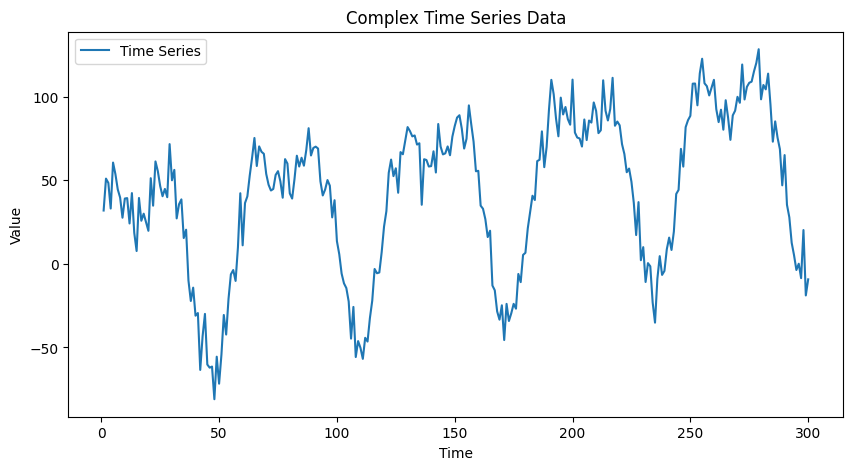

/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


Output()

ERROR:pymc.stats.convergence:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


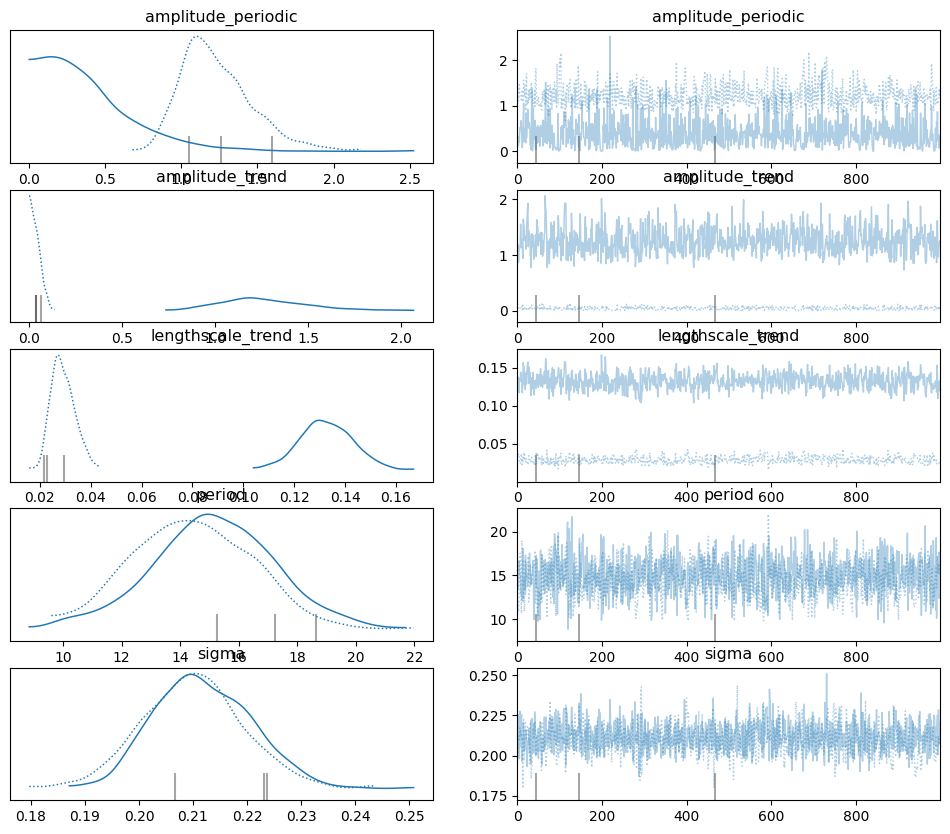

In [ ]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# Generate synthetic time series
t = 300
x = np.arange(1, t + 1)

trend = 0.25 * x + 5
periodic1 = 50 * np.sin(0.1 * x)
periodic2 = 30 * np.cos(0.2 * x)
noise = np.random.normal(0, 10, t)

y = trend + periodic1 + periodic2 + noise

# Normalize the data
x_normalized = (x - np.mean(x)) / np.std(x)
y_normalized = (y - np.mean(y)) / np.std(y)

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Complex Time Series Data')
plt.legend()
plt.show()


#GP Model with PyMC
with pm.Model() as gp_model:
    # Trend component
    amplitude_trend = pm.HalfNormal('amplitude_trend', sigma=1.0)
    lengthscale_trend = pm.Gamma('lengthscale_trend', alpha=2, beta=1)
    cov_trend = amplitude_trend**2 * pm.gp.cov.ExpQuad(1, lengthscale_trend)

    # Periodic components
    amplitude_periodic = pm.HalfNormal('amplitude_periodic', sigma=1.0)
    period = pm.Normal('period', mu=15, sigma=2)
    cov_periodic = amplitude_periodic**2 * pm.gp.cov.Periodic(1, period, lengthscale_trend)

    # Combined covariance
    cov = cov_trend + cov_periodic
    gp = pm.gp.Marginal(cov_func=cov)

    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=0.1)
    y_obs = gp.marginal_likelihood('y_obs', X=x_normalized[:, None], y=y_normalized, noise=sigma)

    # Sampling
    trace = pm.sample(1000, tune=1000, chains=2)
    az.plot_trace(trace)
    plt.show()

**Q3:**

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.


**Q3A:**
We will model a non-linear relationship between inputs and outputs using a Bayesian Neural Network (BNN) with Variational Inference (VI) to estimate the uncertainty.

$y_i \sim N(\mu_i, \sigma^2)$
- We model the observed data $y_i$ as a normal distribution centered around the predicted value $\mu_i$ with noise variance $\sigma^2$.
$
μ=tanh(XW
1
​
 +b
1
​
 )⋅W
2
​
 +b
2
​$

- The function $\mu$ is modeled as a neural network with two hidden layers and $\text{tanh}$ activation.

- The posterior is obtained using ADVI by maximizing the Evidence Lower Bound (ELBO):

$\text{ELBO}(q) = \mathbb{E}_{q(\theta)}[\log p(y|\theta)] - \text{KL}(q(\theta) \parallel p(\theta)]$

This setup allows efficient Bayesian inference for capturing the non-linear patterns in the data.

**Q3A:**


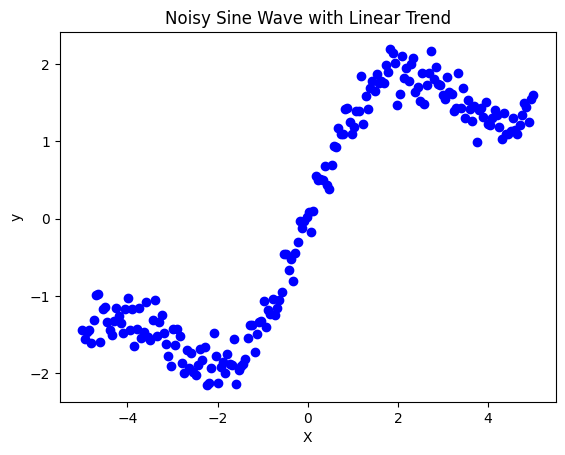

Output()

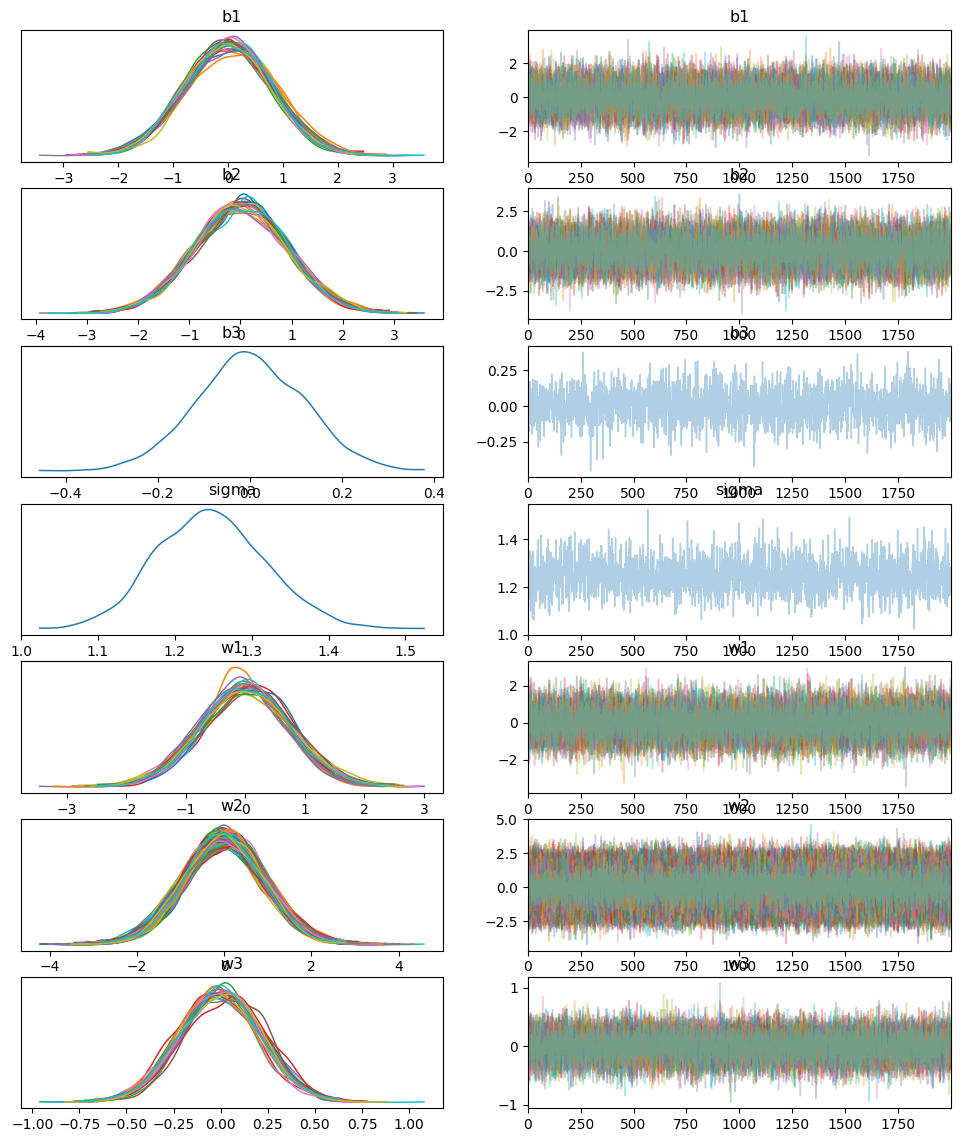

In [ ]:
# Generate synthetic data
t = 200
X = np.linspace(-5, 5, t)[:, None]
y = np.sin(X) + 0.5 * X + 0.2 * np.random.randn(t, 1)

# Plot the data
plt.scatter(X, y, color='blue', label='Observations')
plt.title("Noisy Sine Wave with Linear Trend")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

#BNN with Variational Inference
with pm.Model() as bnn_model:
    # Priors for weights and biases
    w1 = pm.Normal("w1", mu=0, sigma=1, shape=(1, 20))
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(20,))

    w2 = pm.Normal("w2", mu=0, sigma=1, shape=(20, 20))
    b2 = pm.Normal("b2", mu=0, sigma=1, shape=(20,))

    w3 = pm.Normal("w3", mu=0, sigma=1, shape=(20, 1))
    b3 = pm.Normal("b3", mu=0, sigma=1, shape=(1,))

    # Neural network model
    hidden1 = pm.math.tanh(pm.math.dot(X, w1) + b1)
    hidden2 = pm.math.tanh(pm.math.dot(hidden1, w2) + b2)
    output = pm.math.dot(hidden2, w3) + b3

    # Likelihood
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    y_obs = pm.Normal("y_obs", mu=output, sigma=sigma, observed=y)

    # Variational Inference
    vi_approx = pm.fit(method="advi", n=30000)
    trace_vi = vi_approx.sample(2000)
    az.plot_trace(trace_vi)
    plt.show()
